## Hovmoller of Tasselled Cap Wetness, Brightness, Greenness, Rainfall

__What does this notebook do?__ This notebook opens a shape file of transects, allows you to select a transect by number (or plot all sites), and plot a hovmoller diagram of the site tasselled cap indices based on datacube landsat surface reflectance data with contextual BoM rainfall data. You can then plot hovmoller diagrams for the thresholded tasselled cap indices.


__Before you run this notebook:__

__you will need:__

  * a shapefile of the site transects in EPSG 4326 in a known location on raijin
  * to use the rainfall data you will need to request access to project r78 on the NCI
  
__Background:__  

The *Tasseled Cap Index (TCI)* is a method of reducing 6 bands of satellite data (BLUE, GREEN, RED, NIR, SWIR1, SWIR2) to 3 bands (Brightness, Greenness, Wetness) using a Principal Components Analysis and Procrustes' Rotation [(Roberts et al 2018)](##References). This notebook uses the published coefficients of [Crist 1985](##References) as applied to Digital Earth Australia's Landsat satellite data.

*Tasseled cap percentage exceedance:* Percent of observations within epoch where TCI is above chosen threshold (i.e. where pixel has been 'wet' 'green or 'bright'). e default thresholds used in calculating the percentage exceedance are brightness: 4000, greenness 600, wetness -600. 

__Date:__ June 2018

__Authors:__ Bex Dunn, Leo Lymburner

### Set up modules, functions and libraries

In [9]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#get standard libraries
import datetime as dt
import fiona
import geopandas as gpd
import shapely.geometry
from shapely.geometry import shape
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from matplotlib import pyplot as plt
import matplotlib.dates
import numpy as np
import os
import pickle
import rasterio
import rasterio.features
import sys
import xarray as xr

#modules for datacube
import datacube
from datacube.utils import geometry
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/10_Scripts/'))
import DEAPlotting, DEADataHandling, RainfallTools
from BandIndices import tasseled_cap
import TasseledCapTools
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

#alias for datacube
dc = datacube.Datacube(app='dc-BoMrainfallandNbart')

### Set up functions for this notebook

In [10]:
#This defines the function that converts a linear vector file into a string of x,y coordinates
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }

def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    gets the transect
    """
    #Changed for py3 compatibility 17.03.17
    dist = [i for i in range(0, int(geom.length), resolution)]
    #points = zip(*[geom.interpolate(d).coords[0] for d in dist]) py2
    points = list(zip(*[geom.interpolate(d).coords[0] for d in dist])) #py3
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)


## add the path to the input shapefile

In [11]:
#transects file will be the file containing our transects
transects_file = '/g/data/r78/rjd547/groundwater_activities/Thirlmere/Thirlmere_shapefiles/thirlmere_aoi.shp'
transects_df = gpd.read_file(transects_file)

## Define the epoch

In [12]:
#Define temporal range
start_of_epoch = '1987-10-01'#'1987-10-01' 
end_of_epoch =  '2018-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1987-10-01 to 2018-10-01


### Set up query

In [13]:
#use fiona module to open the shape file
transects = fiona.open(transects_file)

#this statement asks you to choose a shapefile. put in a number and press enter.
i = int(input("choose the index of the transect you would like to plot:"))
#for i in range(len(transects)):

geom1 = shape(transects[i]['geometry'])
geom_query1 = geom_query(geom1)
query = {
    'time': (start_of_epoch, end_of_epoch),  
}
query.update(geom_query(geom1, geom_crs=transects.crs_wkt)) 

choose the index of the transect you would like to plot:0


### use the transect dataframe to get transect metadata

In [15]:
#use the transect dataframe to get transect metadata
transect_index = transects_df.index[i]
transect_name = transects_df['Name'][i] 
try:
    print(transect_name)
except TypeError as err:
    print("TypeError: {0}".format(err))
    print(transect_name)

#create a filename for the transect
shape_name = transect_name.split()
shape_name ='_'.join(shape_name)
shape_name=shape_name+'_ix'+str(transect_index)
print(shape_name)

#setup a save directory for our data
savepath ='/g/data/r78/rjd547/groundwater_activities/Thirlmere/Thirlmere_results/HovResults/'+shape_name+'_2/'
try:
        os.mkdir(savepath)
except OSError as err:
        print("OS error: {0}".format(err))

Thirlmere
Thirlmere_ix0


### Check if this notebook has already been run and the data saved:

In [16]:
print(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl')

/g/data/r78/rjd547/groundwater_activities/Thirlmere/Thirlmere_results/HovResults/Thirlmere_ix0_2/hov_data_Thirlmere_ix0_1987-10-01_2018-10-01.pkl


### If not, pull in rainfall and nbart

In [17]:
if os.path.isfile(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl'):
    f = open(savepath+'hov_data_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'rb')
    hov_data = pickle.load(f) 
    f.close()
    if hov_data is not None: 
        print('loaded data from file')
        ds = hov_data['ds']
        Studysite_rain=hov_data['Studysite_rain']
    
else:
    print('did not load data from previous run')
    #use our DEADataHandling function to load landsat data for all sensors in epoch and mask out cloudy scenes
    ds = DEADataHandling.load_clearlandsat(dc, query,product='nbart',masked_prop=0.90)
    print('loaded SR data from DEA, getting rainfall grids')
    #Grab bom_rainfall_grids from the datacube
    Studysite_rain = load_rainfall(query)
    print('loaded bom rainfall grids from DEA')

did not load data from previous run
Loading ls5 pixel quality
    Loading 372 filtered ls5 timesteps
Ignoring SLC-off observations for ls7
Loading ls7 pixel quality
    Loading 68 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 114 filtered ls8 timesteps
Combining and sorting ls5, ls7, ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
loaded SR data from DEA, getting rainfall grids
loaded bom rainfall grids from DEA


### Run the tasseled cap transform and threshold

In [14]:
tci = tasseled_cap(ds)

## Take a look at some of the tasseled cap results

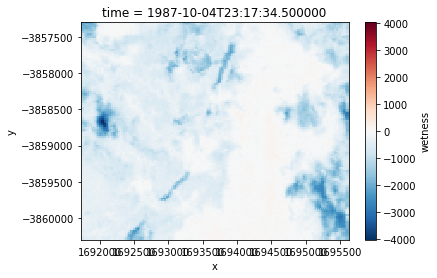

In [15]:
tci.wetness.isel(time=0).plot()

In [16]:
tci_summary= TasseledCapTools.pct_exceedance_tasseled_cap(ds)

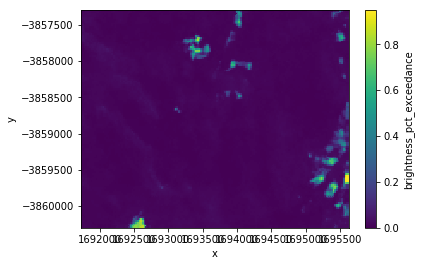

In [17]:
tci_summary.brightness_pct_exceedance.plot()

In [90]:
thresholded_tci = TasseledCapTools.thresholded_tasseled_cap(ds)

In [91]:
thresholded_tci = TasseledCapTools.thresholded_tasseled_cap(ds,tc_bands=['greenness', 'brightness', 'wetness'], greenness_threshold=700, brightness_threshold=4000, wetness_threshold=0)

<xarray.DataArray 'wetness_thresholded' ()>
array(0.0011)

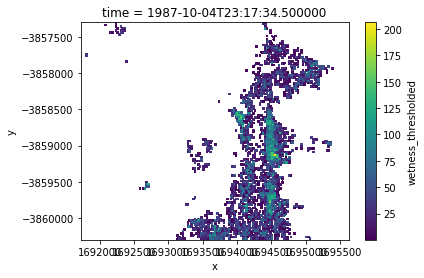

In [92]:
thresholded_tci.wetness_thresholded.isel(time=0).plot()
thresholded_tci.wetness_thresholded.min()

### resample gridded rainfall data

In [69]:
#resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
#Note that the resampling we did means that each year is labelled according to its first day  
rain_sp = Studysite_rain.mean(dim = ('latitude','longitude'))
month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')
year_avg = Studysite_rain.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)
# Create a spatial average
year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="MS").mean() 
  after removing the cwd from sys.path.
/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="AS-OCT").mean() 
  """


### Set up data for Hovmoller plots 

#### Build 2D transect dataset for hovmoller plot

In [70]:
## Compress #check source and destination crs
crs = ds.crs
crs_wkt = ds.crs.wkt
geom_w = warp_geometry(geom1, query['crs'], crs_wkt)
hov_ds= transect(ds, geom_w, 25)

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


In [93]:
tci  = tci.where(tci.brightness <15000, drop=True)
#thresholded_tci = thresholded_tci.where(thresholded_tci.brightness_thresholded <15000, drop=True)
hov_tci = transect(tci, geom_w,25)
hov_thresh_tci =transect(thresholded_tci, geom_w, 25)

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Dataset.sel_points is deprecated: use Dataset.sel()instead.


In [94]:
hov_thresh_tci.wetness_thresholded.max()

<xarray.DataArray 'wetness_thresholded' ()>
array(716.111)

In [95]:
# #calculate NDVI here
# hov_multi_ndvi = ((hov_ds.nir-hov_ds.red)/(hov_ds.nir+hov_ds.red))
# hov_multi =hov_ds
# hov_multi_ndvi_drop = hov_multi_ndvi

### Make Hovmoller plot

transect image: 


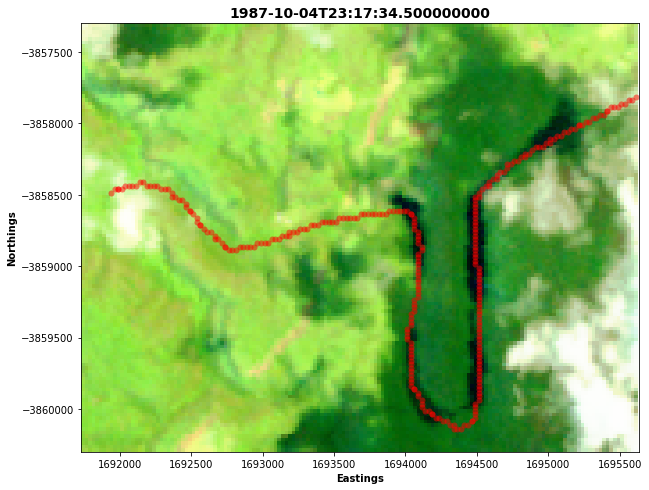

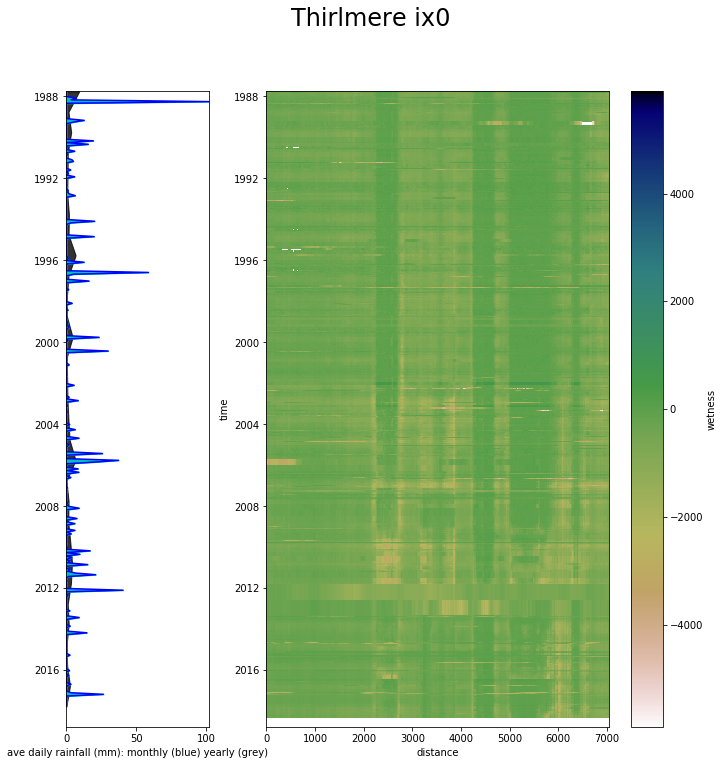

In [96]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_tci.wetness.plot(x='distance', y='time', yincrease = False, cmap = 'gist_earth_r')
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_tci.wetness.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_TCI_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

## plot greenness

transect image: 


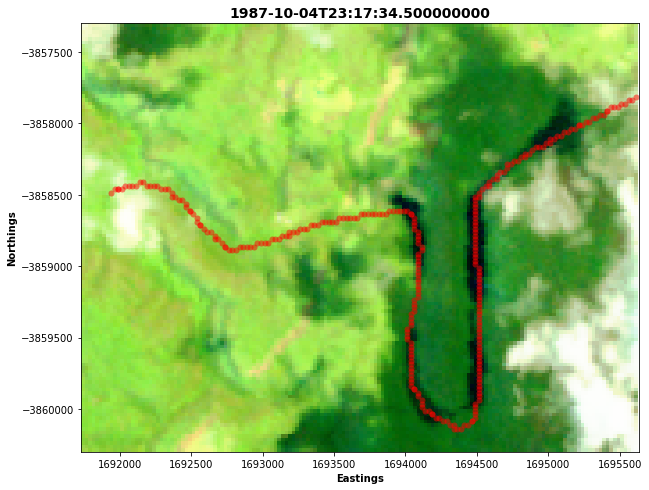

transect tci image: 


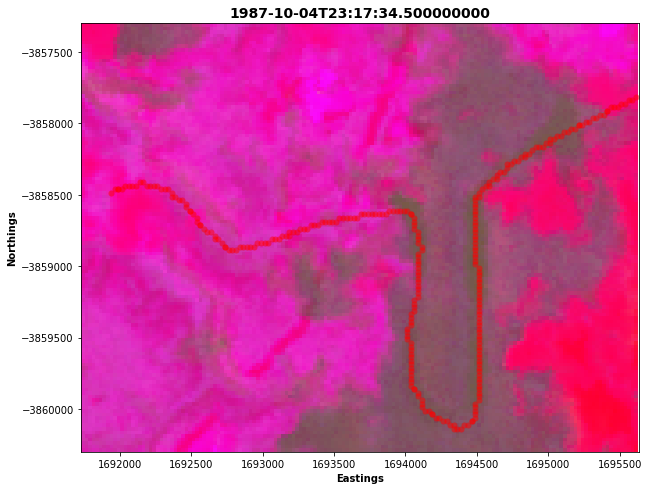

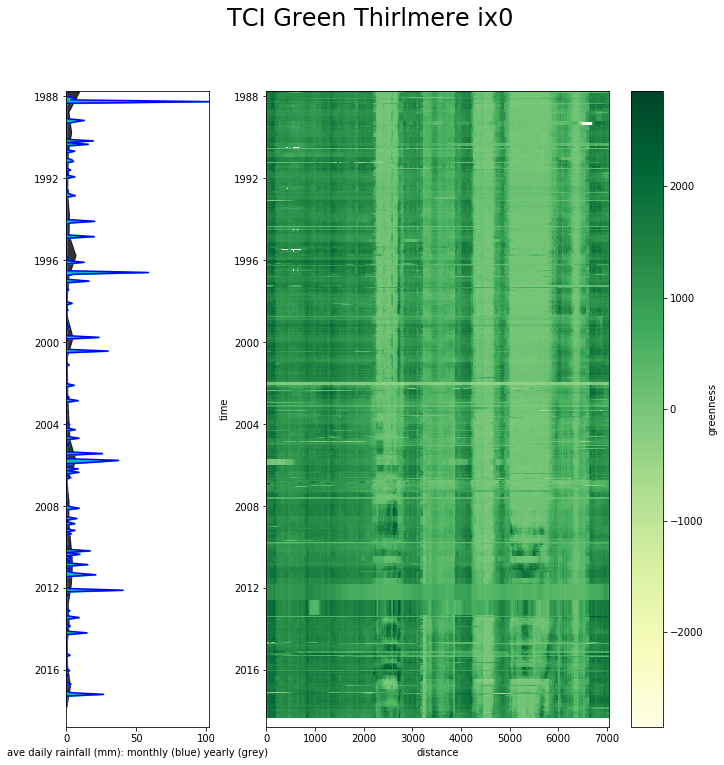

In [97]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect tci image: ')
    DEAPlotting.three_band_image(tci, bands=['brightness','wetness','greenness'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_Hov_TCI_Img_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()    

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_tci.greenness.plot(x='distance', y='time', yincrease = False, cmap = 'YlGn')
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_tci.greenness.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle('TCI Green '+shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_TCI_Green_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

## Plot Brightness

transect image: 


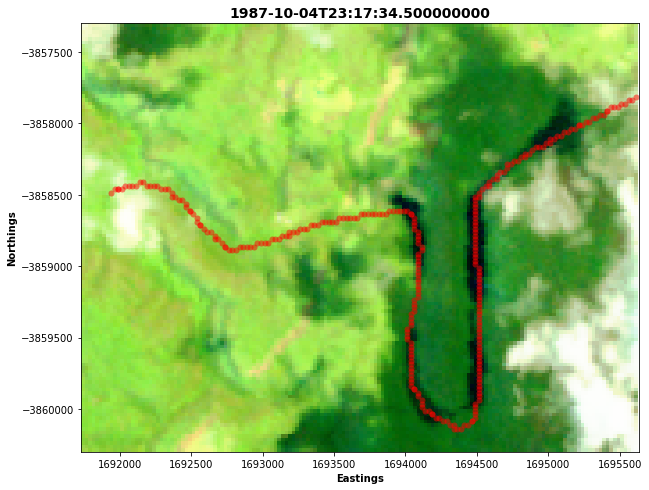

transect tci image: 


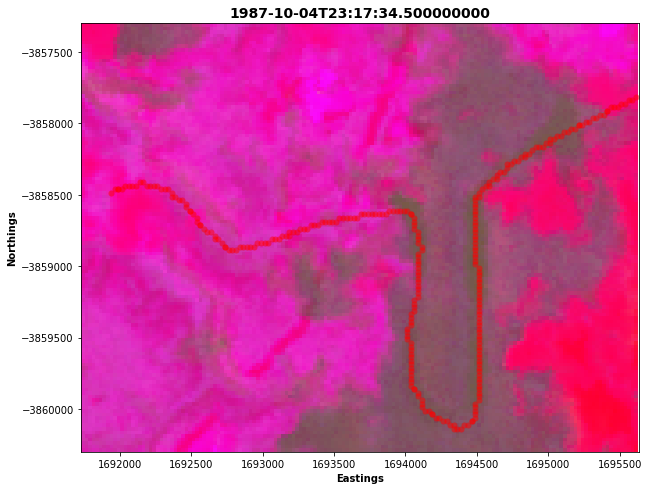

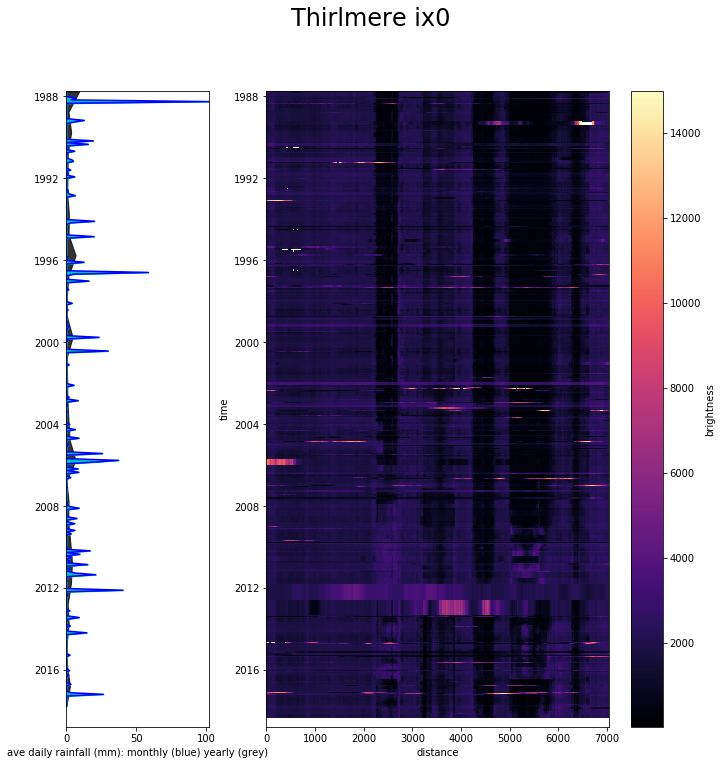

In [85]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect tci image: ')
    DEAPlotting.three_band_image(tci, bands=['brightness','wetness','greenness'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_Hov_TCI_Img_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()    

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_tci.brightness.plot(x='distance', y='time', yincrease = False, cmap = 'magma')
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_tci.brightness.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_TCI_Bright_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

### Save the data to an output file for future use

In [86]:
try:
    #make a dictionary of the data we want to save
    hov_data = {'ds':ds, 'Studysite_rain':Studysite_rain,'rain_sp':rain_sp,'month_sp':month_sp,
                'year_avg':year_avg,'year_avg_sp':year_avg_sp,'hov_tci':hov_tci, 'start_of_epoch': start_of_epoch, 
                'end_of_epoch':end_of_epoch}

    f = open(savepath+'hov_data_tci_{}_{}_{}'.format(shape_name,start_of_epoch,end_of_epoch)+'.pkl', 'wb')
    pickle.dump(hov_data,f) 
    print('saved data to file')
    #pickle.dump(pickle_vars,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()
except:
    print('did not save to file')

saved data to file


## Plot thresholded wetness

transect image: 


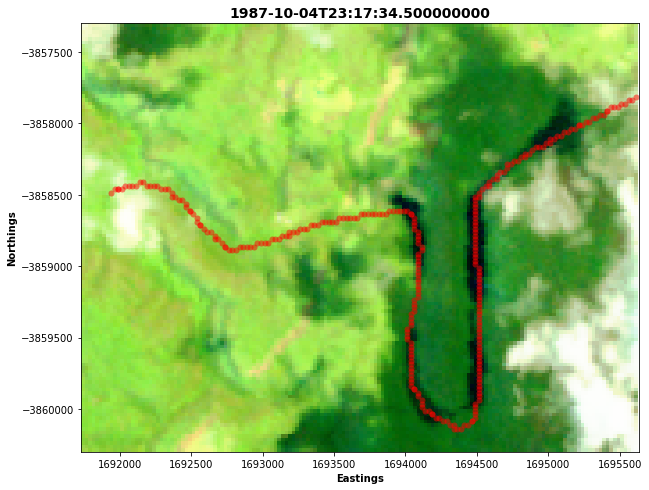

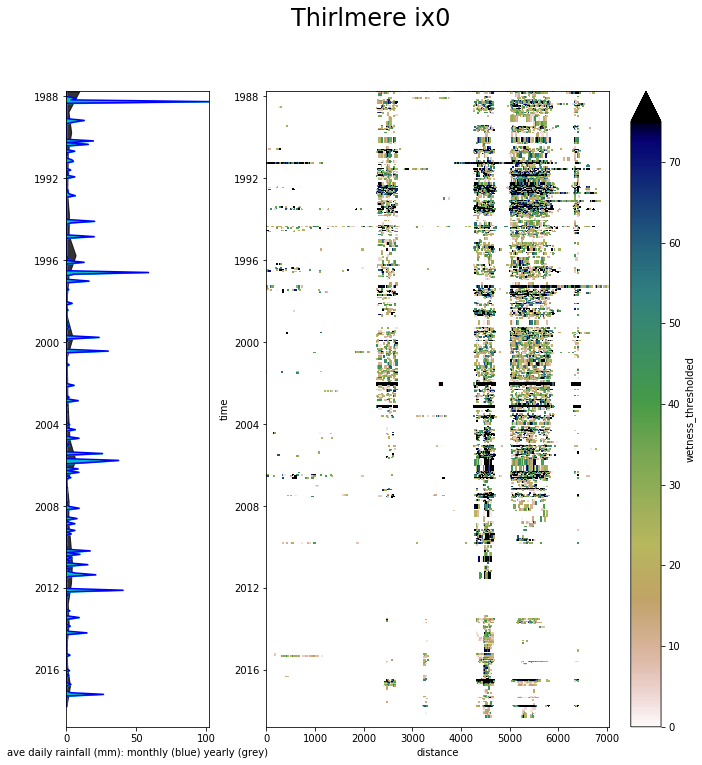

In [99]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_thresh_tci.wetness_thresholded.plot(x='distance', y='time', yincrease = False, cmap = 'gist_earth_r', vmin=0, vmax =75)
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_thresh_tci.wetness_thresholded.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_thresholded_TCI_0_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

## Plot thresholded brightness

transect image: 


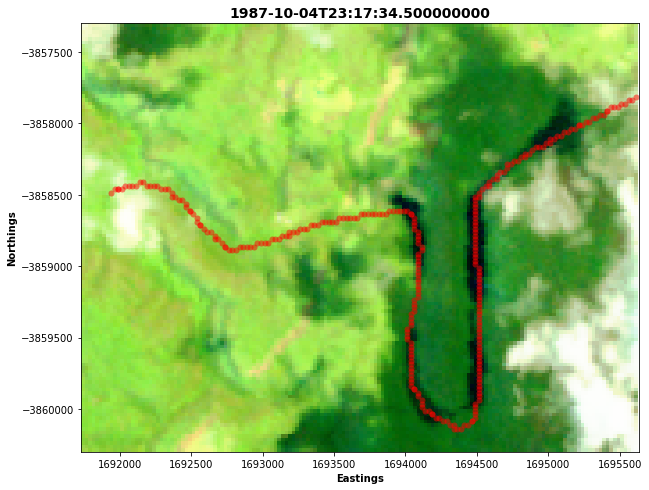

transect tci image: 


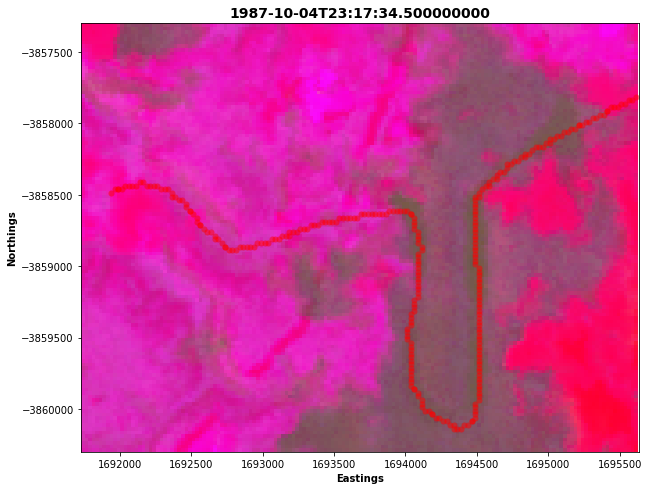

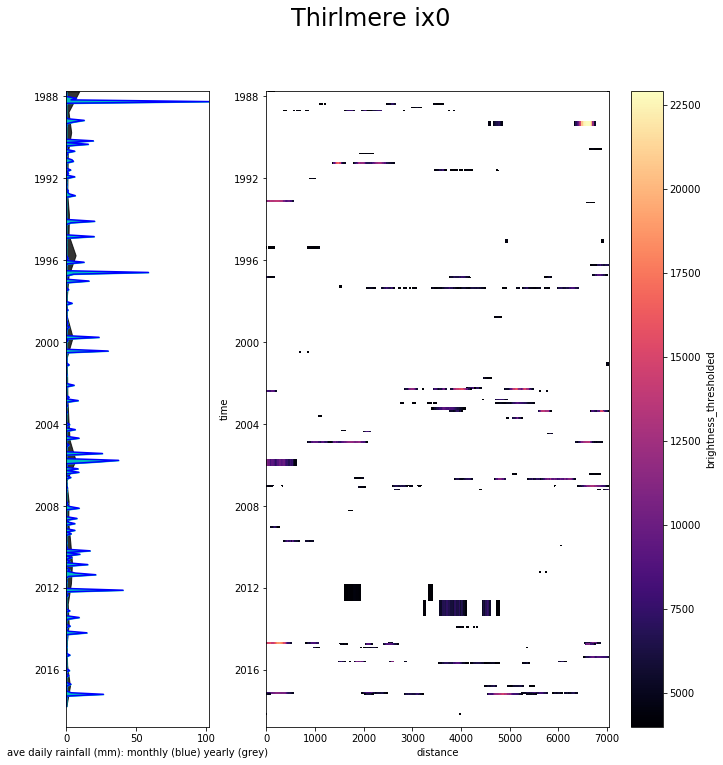

In [33]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect tci image: ')
    DEAPlotting.three_band_image(tci, bands=['brightness','wetness','greenness'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_Hov_TCI_Img_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()    

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_thresh_tci.brightness_thresholded.plot(x='distance', y='time', yincrease = False, cmap = 'magma')
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_thresh_tci.brightness_thresholded.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle(shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_TCI_Bright_thresholded_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

## Plot thresholded greenness

transect image: 


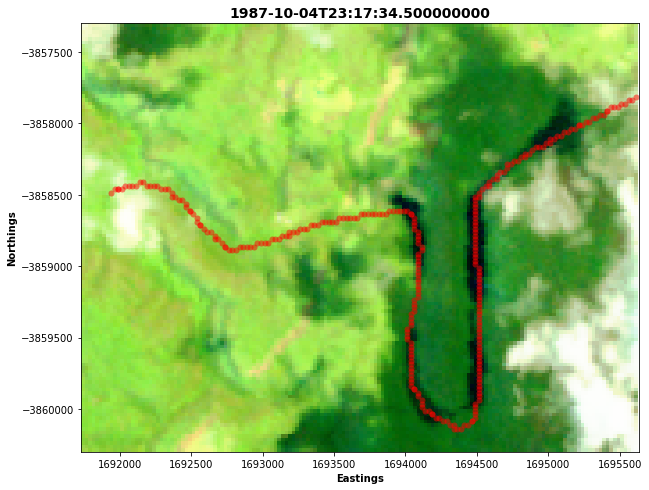

transect tci image: 


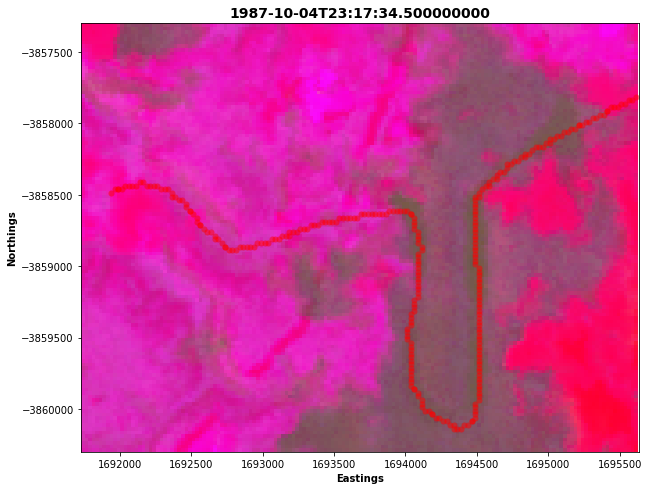

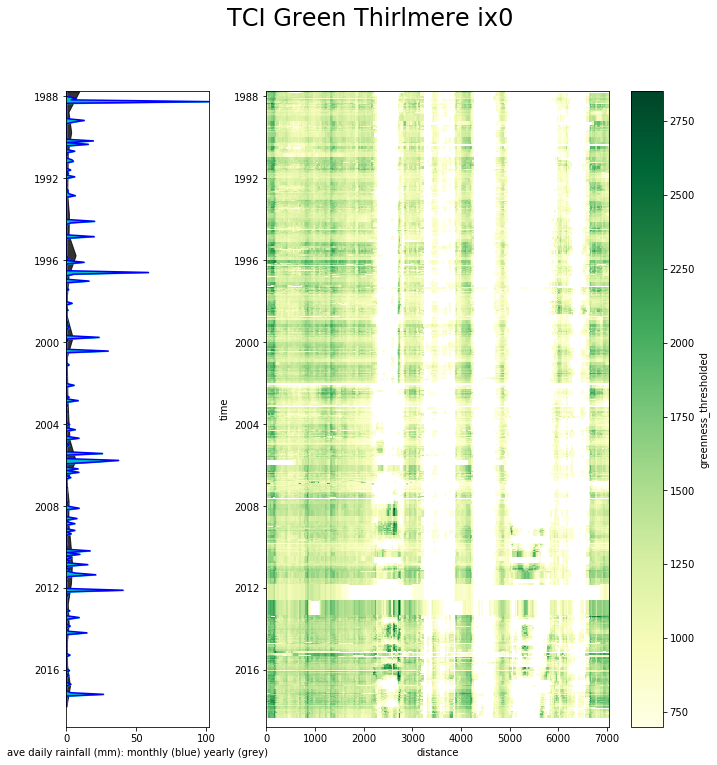

In [98]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect image: ')
    DEAPlotting.three_band_image(ds, bands=['swir1','nir','green'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_HovImg_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #try plotting the first clean time slice to see where we are
    print('transect tci image: ')
    DEAPlotting.three_band_image(tci, bands=['brightness','wetness','greenness'],time =0, contrast_enhance=True)
    plt.scatter(x=hov_ds.coords['x'], y=hov_ds.coords['y'], c='r',
               linewidths='0.01', alpha = 0.5)
    plt.savefig('{}{}_Hov_TCI_Img_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
    plt.show()    

#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'
fig = plt.figure(figsize=(11.27,11.69))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3])
ax1 = plt.subplot(gs[0, 0])
ax1.plot(month_sp.rainfall, month_sp.time, color='b', alpha = 1)
ax1.axes.set_xlabel('ave daily rainfall (mm): monthly (blue) yearly (grey)')

#set up fill time as a datetime 64 object for matplotlib input
#set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))
plt.fill_betweenx(filltime.time.values, zeros, year_avg_sp.rainfall, color ='k', alpha = 0.8)
#set up variables to plot the fill behind the months data
mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
plt.fill_betweenx(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
plt.axis([0, month_sp.rainfall.max(),lastyearhov , firstyearhov])

ax2 = plt.subplot(gs[0, 1])
hov_thresh_tci.greenness_thresholded.plot(x='distance', y='time', yincrease = False, cmap = 'YlGn')
#fig.delaxes(fig.axes[]) #remove current colour bar
plt.axis([0, hov_thresh_tci.greenness_thresholded.distance.max(), lastyearhov , firstyearhov])
ax2.set_anchor("SE")
#make a title replacing underscores with spaces
plt.suptitle('TCI Green '+shape_name.replace('_',' '), fontsize ='24')

#save plot to file
plt.savefig('{}{}_HovPlot_TCI_Green_thresholded_{}_{}.png'.format(savepath,shape_name,start_of_epoch,end_of_epoch),
            bbox_inches='tight')
plt.show()

## References

1. Roberts, D., Dunn,B., Mueller, N. 2018, *Open Data Cube Products Using High-Dimensional Statistics of Time Series*, in press.

2. E. P. Crist, *A tm tasseled cap equivalent transformation for reflectance
factor data*, Remote Sensing of Environment, vol. 17, no. 3, pp. 301-306, 1985.